In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('energy_weather_ohe_model.csv')

In [ ]:
df

,time,total load forecast,total load actual_168,total_non_renewable_168,price actual_48,price actual_72,price actual_168,price actual
0,2014-12-31 23:00:00,26118.0,NaN,NaN,NaN,NaN,NaN,65.41
1,2015-01-01 00:00:00,24934.0,NaN,NaN,NaN,NaN,NaN,64.92
2,2015-01-01 01:00:00,23515.0,NaN,NaN,NaN,NaN,NaN,64.48
3,2015-01-01 02:00:00,22642.0,NaN,NaN,NaN,NaN,NaN,59.32
4,2015-01-01 03:00:00,21785.0,NaN,NaN,NaN,NaN,NaN,56.04
...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00,30619.0,29570.0,11470.0,71.01,77.10,75.30,77.02
35060,2018-12-31 19:00:00,29932.0,28474.0,11500.0,70.72,73.60,74.95,76.16
35061,2018-12-31 20:00:00,27903.0,26583.0,11042.0,70.34,69.21,73.16,74.30
35062,2018-12-31 21:00:00,25450.0,24287.0,9934.0,68.65,67.53,70.39,69.89


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().any()


time                       False
total load forecast        False
total load actual_168      False
total_non_renewable_168    False
price actual_48            False
price actual_72            False
price actual_168           False
price actual               False
dtype: bool

In [ ]:
pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

df = df.dropna()

# Define features and target
features = df.drop(columns=['time', 'price actual'])
target = df['price actual']

# Standard scaling for all numeric types
scaler = StandardScaler()
features_to_scale = features.select_dtypes(include=[np.number])
scaled_features = scaler.fit_transform(features_to_scale)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
data_combined = pd.concat([scaled_features_df, target.reset_index(drop=True)], axis=1)

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        seq_x = data[i:(i + n_steps_in), :-1]
        seq_y = data[(i + n_steps_in):(i + n_steps_in + n_steps_out), -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 24, 48
X, y = create_sequences(data_combined.values, n_steps_in, n_steps_out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X_train.shape[2]  # Number of features

def create_model(units=50, input_shape=(24, 5)):
    model = Sequential([
        LSTM(units, input_shape=input_shape),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, units=100, input_shape=(n_steps_in, n_features))

# Define parameter distribution
param_dist = {
    'units': [50, 100],
    'batch_size': [16, 32],
    'epochs': [10, 20],
}

# Create RandomizedSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring=mape_scorer, cv=3, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/10
1045/1045 [==============================] - 8s 5ms/step - loss: 1407.5305 - val_loss: 397.4846
Epoch 2/10
1045/1045 [==============================] - 5s 5ms/step - loss: 220.6446 - val_loss: 140.8250
Epoch 3/10
1045/1045 [==============================] - 5s 4ms/step - loss: 123.1330 - val_loss: 118.9441
Epoch 4/10
1045/1045 [==============================] - 6s 5ms/step - loss: 111.7335 - val_loss: 112.5295
Epoch 5/10
1045/1045 [==============================] - 9s 8ms/step - loss: 108.0296 - val_loss: 111.4293
Epoch 6/10
1045/1045 [==============================] - 9s 9ms/step - loss: 106.0175 - val_loss: 106.9493
Epoch 7/10
1045/1045 [==============================] - 9s 9ms/step - loss: 102.7822 - val_loss: 103.1891
Epoch 8/10
1045/1045 [==============================] - 5s 4ms/step - loss: 99.0513 - val_loss: 99.6526
Epoch 9/10
1045/1045 [==============================] - 5s 4ms/step - loss: 96.0444 - val_loss: 97.1456
Epoch 10/10
581/581 [============================

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(input_shape=(24, 6), model=<function create_model at 0x796fb9728670>, units=100),
                   param_distributions={'batch_size': [16, 32],
                                        'epochs': [10, 20],
                                        'units': [50, 100]},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

436/436 [==============================] - 1s 2ms/step
MAPE: 10.44%


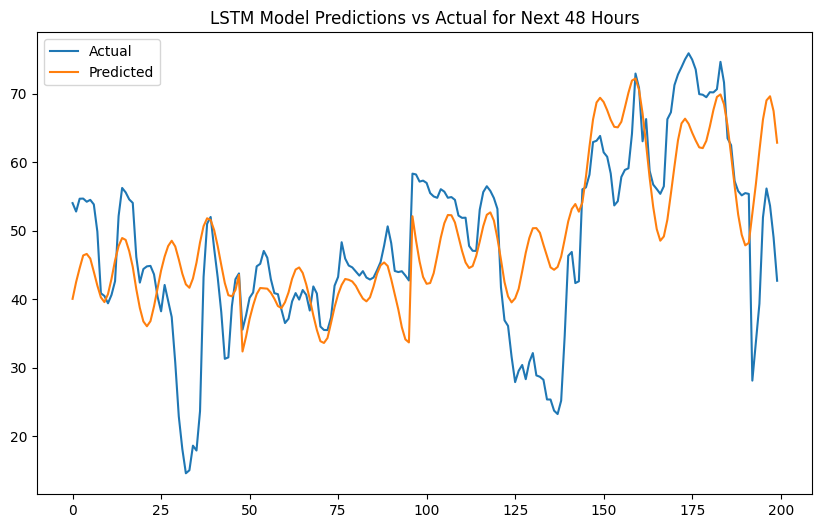

   Actual Price  Predicted Price
0         54.03        40.061314
1         52.80        42.510727
2         54.67        44.540646
3         54.69        46.395000
4         54.23        46.613853


In [ ]:
# Best model
best_model = random_search.best_estimator_.model

# Predictions with the best model
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape*100:.2f}%')

# Plotting predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten()[:200], label='Actual')  # Plotting a subset for clarity
plt.plot(y_pred.flatten()[:200], label='Predicted')
plt.title('LSTM Model Predictions vs Actual for Next 48 Hours')
plt.legend()
plt.show()


# Display a table with actual vs. predicted prices
results_df = pd.DataFrame({'Actual Price': y_test.flatten(), 'Predicted Price': y_pred.flatten()})
print(results_df.head())  # Displaying the first few rows for brevity

In [ ]:
best_hyperparameters = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best Hyperparameters:
units: 100
epochs: 20
batch_size: 16


In [ ]:
best_keras_model = random_search.best_estimator_.model_  # Note the correct attribute is model_ for scikeras 0.6.0 onwards

# Check if the best model is correctly referenced
if hasattr(best_keras_model, 'save'):
    # Save the best model
    best_keras_model.save('RNN_LSTM_model_saved')
    print("Model saved successfully.")
else:
    print("The best model could not be saved because it is not a Keras model instance.")

Model saved successfully.


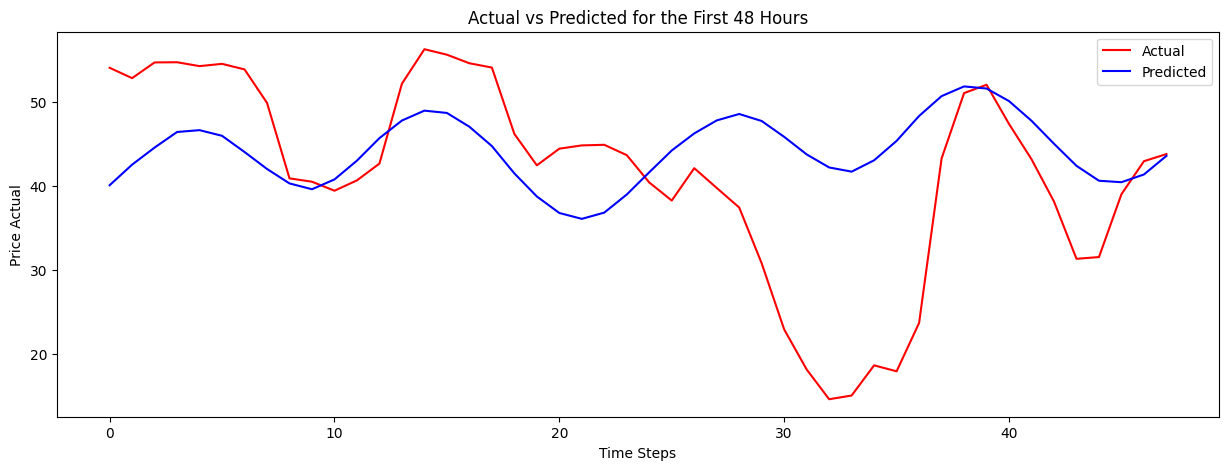

In [ ]:
# Assuming you have y_pred and y_test, and each sample represents a 48-hour prediction

# Select the first 48-hour period for actual and predicted
# Assuming each sample in y_test and y_pred corresponds to a 48-hour prediction
actual_first_48 = y_test[0]  # This selects the first 48 hours worth of actual data
predicted_first_48 = y_pred[0]  # This selects the first 48 hours worth of predicted data

# Visualizing the first 48-hour predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(actual_first_48, 'r', label='Actual')
plt.plot(predicted_first_48, 'b', label='Predicted')
plt.title('Actual vs Predicted for the First 48 Hours')
plt.xlabel('Time Steps')
plt.ylabel('Price Actual')
plt.legend()
plt.show()

In [ ]:
import os

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/IBM Capstone Project')

In [ ]:
pd.set_option('display.max_rows', None)
final_df

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IBM Capstone Project/Data/energy_weather_ohe_model.csv')

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1rHaqSxySJZSFHpdMLAkBa8CH1Q5WfDk-/IBM Capstone Project'

In [ ]:
df.tail()

,time,total load forecast,total load actual_168,total_non_renewable_168,price actual_48,price actual_72,price actual_168,price actual
35059,2018-12-31 18:00:00,30619.0,29570.0,11470.0,71.01,77.10,75.30,77.02
35060,2018-12-31 19:00:00,29932.0,28474.0,11500.0,70.72,73.60,74.95,76.16
35061,2018-12-31 20:00:00,27903.0,26583.0,11042.0,70.34,69.21,73.16,74.30
35062,2018-12-31 21:00:00,25450.0,24287.0,9934.0,68.65,67.53,70.39,69.89
35063,2018-12-31 22:00:00,24424.0,23231.0,10027.0,68.31,64.08,70.20,69.88


1/1 [==============================] - 1s 564ms/step


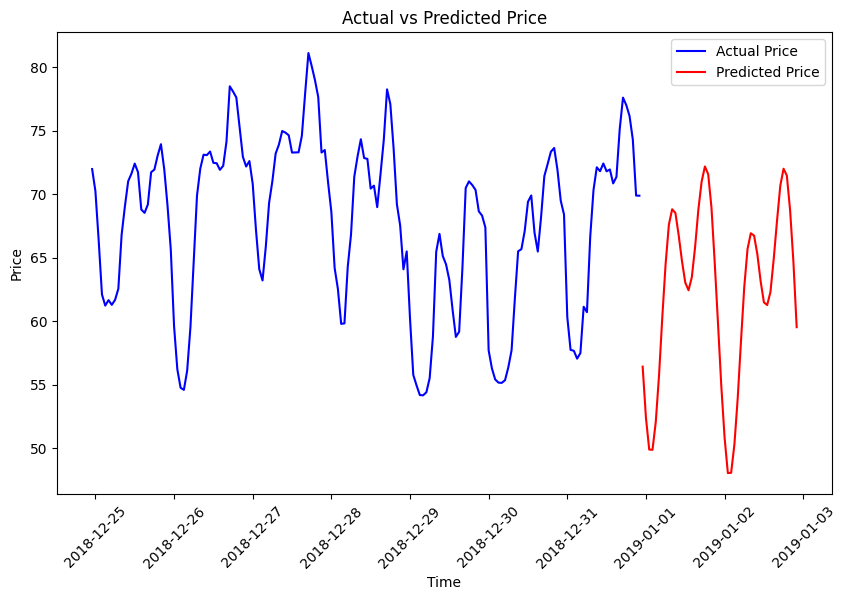

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

features = ['total load forecast', 'total load actual_168', 'total_non_renewable_168', 'price actual_48', 'price actual_72', 'price actual_168']
X = df[features].iloc[-24:]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)  # You should use .transform() if scaler is already fitted
scaled_features_df = pd.DataFrame(scaled_features, columns=features)

X_reshaped = scaled_features.reshape(1, 24, len(features))

# Load your trained model (adjust the path as necessary)
saved_model_path = '/content/drive/MyDrive/IBM Capstone Project/Data/RNN_LSTM_model_saved'
model = load_model(saved_model_path)

# Make predictions
y_predicted = model.predict(X_reshaped)

y_predicted_flat = y_predicted.flatten()  # This will convert y_predicted from (1, 48) to (48,)


# Ensure prediction_times spans 48 periods
last_time_stamp = df['time'].iloc[-1]
prediction_times = pd.date_range(start=last_time_stamp + pd.Timedelta(hours=1), periods=48, freq='H')


# Proceed with your plotting, now using the correctly shaped arrays
plt.figure(figsize=(10, 6))
plt.plot(df['time'].iloc[-168:], df['price actual'].iloc[-168:], label='Actual Price', color='blue')
plt.plot(prediction_times, y_predicted_flat, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


AttributeError: 'DatetimeIndex' object has no attribute 'type'

In [ ]:
scaled_features_df

,total load forecast,total load actual_168,total_non_renewable_168,price actual_48,price actual_72,price actual_168
0,-0.495973,-0.434028,-0.282605,0.512962,0.300266,0.279506
1,-1.078355,-1.055216,-0.894588,-0.404840,-0.172685,-0.268838
2,-1.456693,-1.446436,-0.907266,-1.181575,-1.073738,-1.060417
3,-1.657731,-1.651666,-1.250714,-1.326125,-1.412143,-1.941608
4,-1.716931,-1.710609,-2.201536,-1.458483,-1.972753,-1.990682
5,-1.643908,-1.586921,-1.975644,-1.461967,-1.964598,-2.146437
6,-1.251447,-1.184401,-1.279527,-1.420169,-1.057429,-1.164965
7,-0.550966,-0.501521,-0.594936,-1.226856,-0.539630,-0.851320
8,0.026607,0.084851,-0.018680,-0.655625,0.392002,0.411792
9,0.700042,0.842859,0.165721,0.507737,0.718175,0.571814
